# Pokemon Data Extraction

Extract Pokemon Data from IPhone6 Screenshots using the Tesseract OCR library

In [16]:
from tesserocr import PyTessBaseAPI
from PIL import Image
from io import BytesIO
from IPython import display

api = PyTessBaseAPI()
filename = 'vap.png'

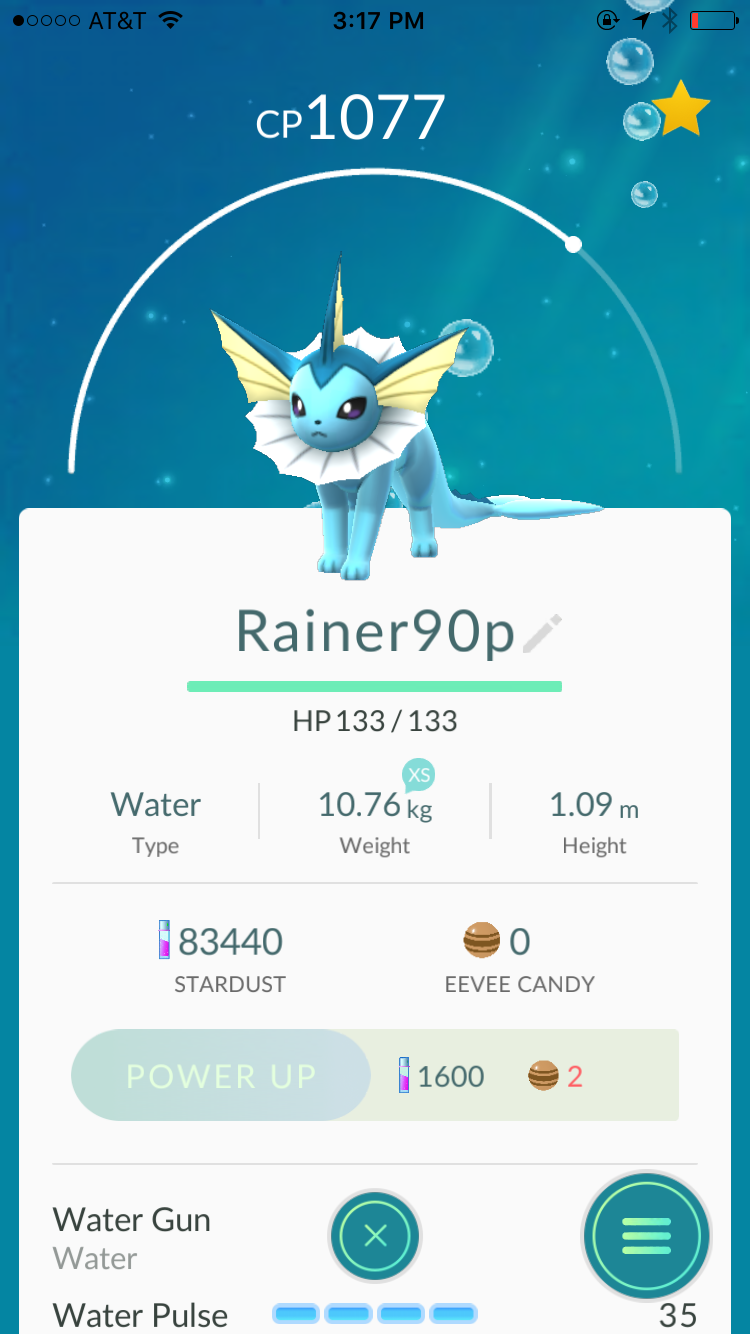

In [27]:
im = Image.open(filename)

def display_image(im, width=100):
    b = BytesIO()
    im.save(b, format='png')
    display.display(display.Image(data=b.getvalue(), width=width))
    
display_image(im)

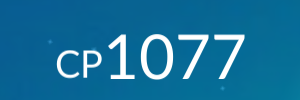

u'CP1077'

In [33]:
def extract_string(im, box, extract=True):
    cim = im.crop(box); 
    display_image(cim)
    if extract:
        api.SetImage(cim)
        text = api.GetUTF8Text()
        return text.strip()
    else:
        return ''
    
cp_box = (200,60,500,160)
extract_string(im, cp_box)